<a href="https://colab.research.google.com/github/arimbawa/Big-Data/blob/main/03_Big_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Data Cleaning menggunakan Pandas dan Numpy

import pandas as pd
import numpy as np

# Contoh dataset IoT (debit air)
data = {
    "timestamp": pd.date_range("2025-01-01", periods=10, freq="h"),
    "flow_lpm": [10, 15, None, 500, 20, 25, None, 30, 1000, 22],  # ada missing & outlier
    "location": ["A", "A", "B", "B", "C", "C", "C", None, "A", "A"]  # ada missing
}

df = pd.DataFrame(data)
print("Data Asli:\n", df)

# 1. Handling Missing Values
df.fillna({"flow_lpm": df["flow_lpm"].mean()}, inplace=True)
df.fillna({"location": "Unknown"}, inplace=True)

# 2. Handling Outliers (flow > 200 dianggap error → replace dengan median)
median_flow = df["flow_lpm"].median()
df.loc[df["flow_lpm"] > 200, "flow_lpm"] = median_flow

# 3. Handling Duplicates
df.drop_duplicates(inplace=True)

# 4. Standardisasi / Normalisasi
df["flow_norm"] = (df["flow_lpm"] - df["flow_lpm"].min()) / (df["flow_lpm"].max() - df["flow_lpm"].min())

print("\nData Setelah Cleaning:\n", df)


Data Asli:
             timestamp  flow_lpm location
0 2025-01-01 00:00:00      10.0        A
1 2025-01-01 01:00:00      15.0        A
2 2025-01-01 02:00:00       NaN        B
3 2025-01-01 03:00:00     500.0        B
4 2025-01-01 04:00:00      20.0        C
5 2025-01-01 05:00:00      25.0        C
6 2025-01-01 06:00:00       NaN        C
7 2025-01-01 07:00:00      30.0     None
8 2025-01-01 08:00:00    1000.0        A
9 2025-01-01 09:00:00      22.0        A

Data Setelah Cleaning:
             timestamp  flow_lpm location  flow_norm
0 2025-01-01 00:00:00      10.0        A      0.000
1 2025-01-01 01:00:00      15.0        A      0.250
2 2025-01-01 02:00:00      27.5        B      0.875
3 2025-01-01 03:00:00      27.5        B      0.875
4 2025-01-01 04:00:00      20.0        C      0.500
5 2025-01-01 05:00:00      25.0        C      0.750
6 2025-01-01 06:00:00      27.5        C      0.875
7 2025-01-01 07:00:00      30.0  Unknown      1.000
8 2025-01-01 08:00:00      27.5        A    

In [ ]:
!pip install pyspark

In [ ]:
# Data Cleaning menggunakan pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean

# Buat SparkSession
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Dataset contoh
data = [
    ("2025-01-01 00:00:00", 10, "A"),
    ("2025-01-01 01:00:00", 15, "A"),
    ("2025-01-01 02:00:00", None, "B"),
    ("2025-01-01 03:00:00", 500, "B"),   # outlier
    ("2025-01-01 04:00:00", 20, "C"),
    ("2025-01-01 05:00:00", 25, "C"),
    ("2025-01-01 06:00:00", None, "C"), # missing
    ("2025-01-01 07:00:00", 30, None),  # missing
    ("2025-01-01 08:00:00", 1000, "A"), # outlier
    ("2025-01-01 09:00:00", 22, "A")
]

columns = ["timestamp", "flow_lpm", "location"]
df = spark.createDataFrame(data, columns)

print("Data Asli:")
df.show()

# 1. Imputasi missing values (flow_lpm dengan rata-rata, location dengan "Unknown")
mean_val = df.select(mean(col("flow_lpm"))).collect()[0][0]
df = df.withColumn("flow_lpm", when(col("flow_lpm").isNull(), mean_val).otherwise(col("flow_lpm")))
df = df.withColumn("location", when(col("location").isNull(), "Unknown").otherwise(col("location")))

# 2. Handling outliers (flow > 200 → ganti dengan median)
median_val = df.approxQuantile("flow_lpm", [0.5], 0.1)[0]
df = df.withColumn("flow_lpm", when(col("flow_lpm") > 200, median_val).otherwise(col("flow_lpm")))

# 3. Normalisasi Min-Max
min_val, max_val = df.agg({"flow_lpm": "min"}).collect()[0][0], df.agg({"flow_lpm": "max"}).collect()[0][0]
df = df.withColumn("flow_norm", (col("flow_lpm") - min_val) / (max_val - min_val))

print("\nData Setelah Cleaning:")
df.show()


Data Asli:
+-------------------+--------+--------+
|          timestamp|flow_lpm|location|
+-------------------+--------+--------+
|2025-01-01 00:00:00|      10|       A|
|2025-01-01 01:00:00|      15|       A|
|2025-01-01 02:00:00|    NULL|       B|
|2025-01-01 03:00:00|     500|       B|
|2025-01-01 04:00:00|      20|       C|
|2025-01-01 05:00:00|      25|       C|
|2025-01-01 06:00:00|    NULL|       C|
|2025-01-01 07:00:00|      30|    NULL|
|2025-01-01 08:00:00|    1000|       A|
|2025-01-01 09:00:00|      22|       A|
+-------------------+--------+--------+


Data Setelah Cleaning:
+-------------------+--------+--------+---------+
|          timestamp|flow_lpm|location|flow_norm|
+-------------------+--------+--------+---------+
|2025-01-01 00:00:00|    10.0|       A|      0.0|
|2025-01-01 01:00:00|    15.0|       A|     0.25|
|2025-01-01 02:00:00|    22.0|       B|      0.6|
|2025-01-01 03:00:00|    22.0|       B|      0.6|
|2025-01-01 04:00:00|    20.0|       C|      0.5|
|202

/tmp/ipython-input-4080620428.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range("2025-01-01", periods=10, freq="H"),
/tmp/ipython-input-4080620428.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["flow_lpm"].fillna(df_clean["flow_lpm"].mean(), inplace=True)
/tmp/ipython-input-4080620428.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavi

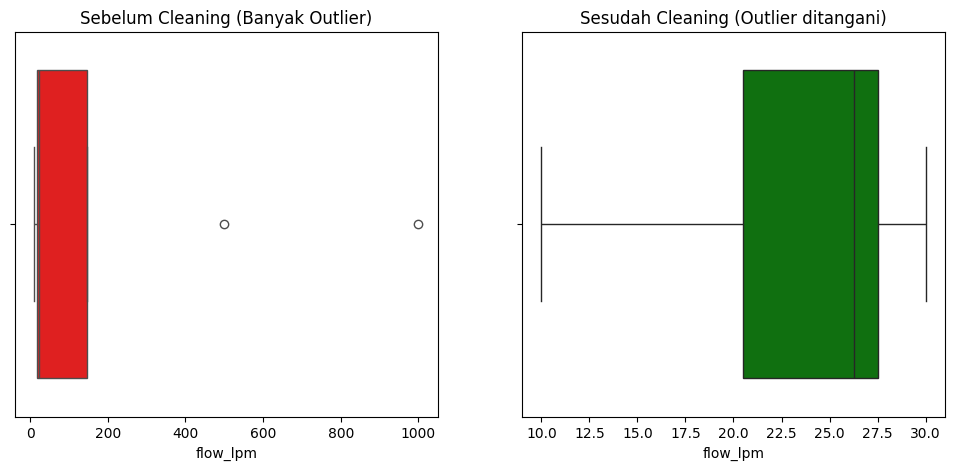

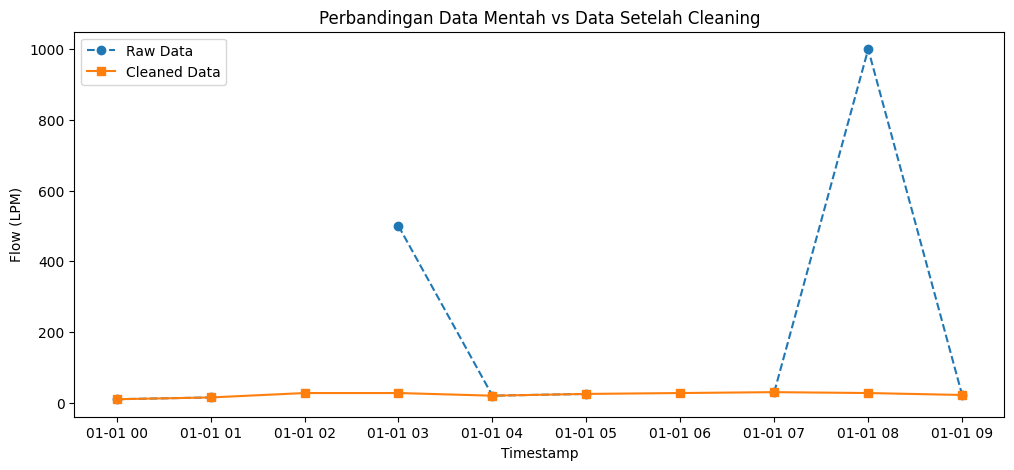

In [ ]:
# Visualisasi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Dataset Contoh IoT ===
data = {
    "timestamp": pd.date_range("2025-01-01", periods=10, freq="H"),
    "flow_lpm": [10, 15, None, 500, 20, 25, None, 30, 1000, 22],  # ada missing & outlier
    "location": ["A", "A", "B", "B", "C", "C", "C", None, "A", "A"]  # ada missing
}
df_raw = pd.DataFrame(data)

# === Copy data untuk cleaning ===
df_clean = df_raw.copy()

# 1. Handling Missing Values
df_clean["flow_lpm"].fillna(df_clean["flow_lpm"].mean(), inplace=True)
df_clean["location"].fillna("Unknown", inplace=True)

# 2. Handling Outliers (anggap >200 sebagai error → replace median)
median_flow = df_clean["flow_lpm"].median()
df_clean.loc[df_clean["flow_lpm"] > 200, "flow_lpm"] = median_flow

# 3. Normalisasi (Min-Max)
df_clean["flow_norm"] = (df_clean["flow_lpm"] - df_clean["flow_lpm"].min()) / (df_clean["flow_lpm"].max() - df_clean["flow_lpm"].min())

# === Visualisasi Sebelum & Sesudah ===

plt.figure(figsize=(12,5))

# Boxplot sebelum cleaning
plt.subplot(1,2,1)
sns.boxplot(x=df_raw["flow_lpm"], color="red")
plt.title("Sebelum Cleaning (Banyak Outlier)")

# Boxplot sesudah cleaning
plt.subplot(1,2,2)
sns.boxplot(x=df_clean["flow_lpm"], color="green")
plt.title("Sesudah Cleaning (Outlier ditangani)")

plt.show()

# Plot garis untuk lihat perubahan nilai
plt.figure(figsize=(12,5))
plt.plot(df_raw["timestamp"], df_raw["flow_lpm"], "o--", label="Raw Data")
plt.plot(df_clean["timestamp"], df_clean["flow_lpm"], "s-", label="Cleaned Data")
plt.xlabel("Timestamp")
plt.ylabel("Flow (LPM)")
plt.title("Perbandingan Data Mentah vs Data Setelah Cleaning")
plt.legend()
plt.show()

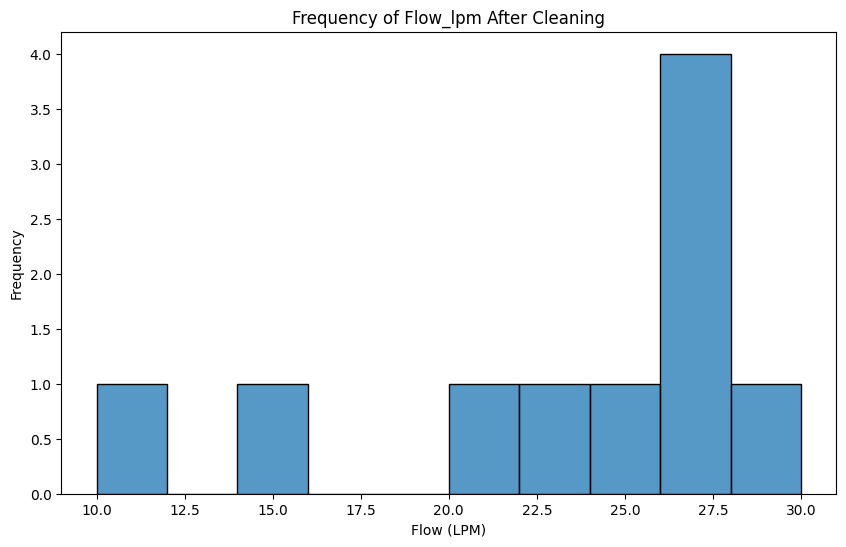

In [ ]:
# Create a bar chart of flow_lpm frequency
plt.figure(figsize=(10, 6))
sns.histplot(df_clean["flow_lpm"], bins=10, kde=False)
plt.title("Frequency of Flow_lpm After Cleaning")
plt.xlabel("Flow (LPM)")
plt.ylabel("Frequency")
plt.show()